<a href="https://colab.research.google.com/github/Eduzc07/machinelearning/blob/master/2_Finance/StockPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Stock Predictions**

As first step, all the libraries should be added.

In [1]:
## Open source RL: https://docs.google.com/spreadsheets/d/1EeFPd-XIQ3mq_9snTlAZSsFY7Hbnmd7P5bbT8LPuMn0/edit#gid=0
import numpy as np
import pandas as pd
#import seaborn as sns
import math
from datetime import datetime, timedelta

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn import preprocessing
from sklearn import ensemble
from sklearn import datasets

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import style
from matplotlib.dates import MONDAY
print("matplotlib v%s"%(mpl.__version__))
%matplotlib inline

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Dense
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.losses import Huber
from keras.optimizers import SGD

#sns.set()

matplotlib v3.0.3


Using TensorFlow backend.


In [2]:
!pip install yfinance --upgrade --no-cache-dir

  Created wheel for yfinance: filename=yfinance-0.1.45-cp36-none-any.whl size=14652 sha256=74b351f9f6b9ac3df2e9414893756cc47fd6ba9f2bd73560882de0d8cba9ffc6
  Stored in directory: /tmp/pip-ephem-wheel-cache-sgxs8cod/wheels/0c/d1/df/aa9a7744a4ac353cc9a1f2c3aaea7c1f457fc49de4286f2d88
Successfully built yfinance


In [3]:
## Save future files to your drive
## In this notebook control for multiple testing
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
%cd "/content/drive/My Drive/Data/Stocks"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Data/Stocks


In [4]:
from pandas_datareader import data as pdr
import os.path
import fix_yahoo_finance as yf

# --------------------------------------------------------------------------------
# Input
# --------------------------------------------------------------------------------
name = 'AAPL'
# name = 'TSLA'
# name = 'GOOG'
# name = 'NVDA'
# name = 'SPOT'
# name = 'JPM'
# --------------------------------------------------------------------------------

nameFile = '%s.csv'%name
bForce = True #Change to true to force update

if os.path.isfile(nameFile) and not bForce:
  print('%s already exist. It will be read.'%name)
  # Read file if it has been saved
  df_full = pd.read_csv(nameFile)
else:
  yf.pdr_override()
  df_full = pdr.get_data_yahoo(name, start="2014-01-01").reset_index()
  df_full.to_csv(nameFile, index=False)

# Converts string to datetime
df_full['Date'] = pd.to_datetime(df_full.Date, format='%Y-%m-%d')
# Set the index of dataframe to date column
df_full = df_full.set_index('Date')

df_full.head()

[*********************100%***********************]  1 of 1 downloaded


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,79.382858,79.575714,78.860001,79.018570,71.320679,58671200
2014-01-03,78.980003,79.099998,77.204285,77.282860,69.754066,98116900
2014-01-06,76.778572,78.114288,76.228569,77.704285,70.134438,103152700
2014-01-07,77.760002,77.994286,76.845711,77.148575,69.632866,79302300
2014-01-08,76.972855,77.937141,76.955711,77.637146,70.073868,64632400


# **Trading Strategies**




## 1. Strategie using High Low Percentage and Percentage Change.

It has been done following the next steps [In 12 minutes: Stocks Analysis](https://towardsdatascience.com/in-12-minutes-stocks-analysis-with-pandas-and-scikit-learn-a8d8a7b50ee7)


### Rolling Mean (Moving Average)

Rolling mean/Moving Average (MA) smooths out price data by creating a constantly updated average price. This is useful to cut down “noise” in our price chart. Furthermore, this Moving Average could act as “Resistance” meaning from the downtrend and uptrend of stocks you could expect it will follow the trend and less likely to deviate outside its resistance point.

In [0]:
close_px = df_full['Adj Close']
mavg = close_px.rolling(window=100).mean()
#close_px.head()

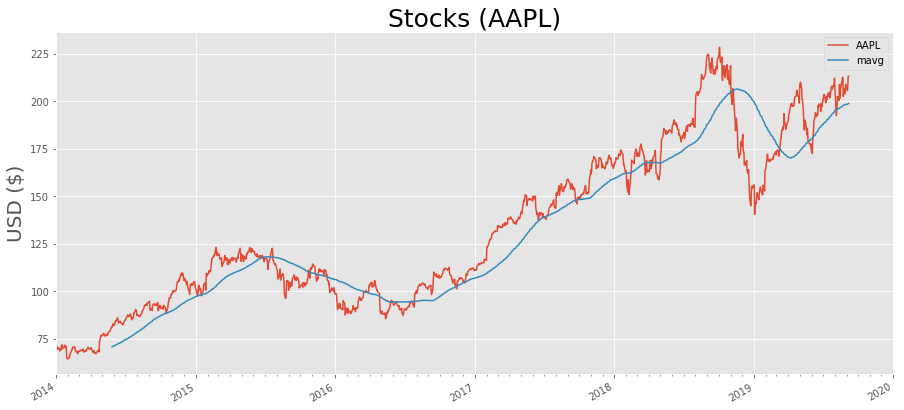

In [10]:
# Adjusting the size of matplotlib
mpl.rc('figure', figsize=(15, 7))

# Adjusting the style of matplotlib
style.use('ggplot')

#Create fig to plot
fig, ax = plt.subplots()

plt.plot(close_px, label=name)
plt.plot(mavg, label='mavg')
plt.legend()
#plt.xlabel('Date', fontsize = 20)
plt.ylabel('USD ($)', fontsize = 20)

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

# round to nearest years.
datemin = np.datetime64(df_full.index.min(), 'Y')
datemax = np.datetime64(df_full.index.max(), 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

#format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.set_title('Stocks (%s)'%name, fontsize = 25)
#ax.grid(True)

fig.autofmt_xdate()
plt.show()

### Return Deviation — to determine risk and return

Expected Return measures the mean, or expected value, of the probability distribution of investment returns. The expected return of a portfolio is calculated by multiplying the weight of each asset by its expected return and adding the values for each investment — Investopedia.


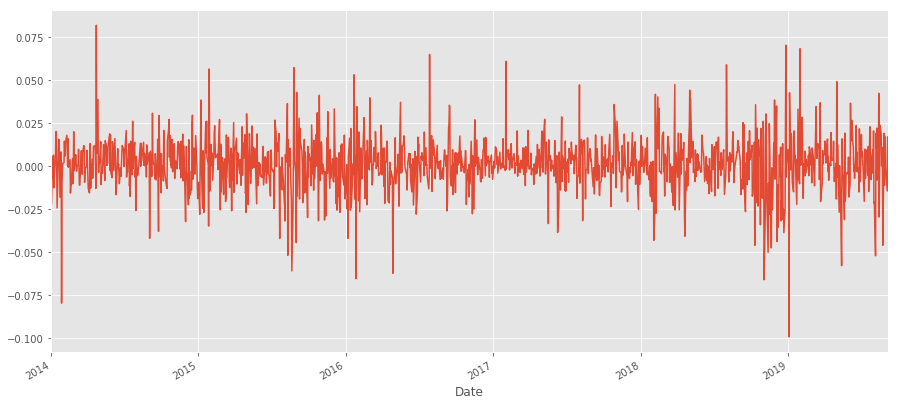

In [0]:
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')

### Predicting Stocks Price

The prediction will be done using some features:  High Low Percentage and Percentage Change.

In [0]:
dfreg = df_full.loc[:,['Adj Close','Volume']]
#High Low Percentage
dfreg['HL_PCT'] = (df_full['High'] - df_full['Low']) / df_full['Close'] * 100.0
#Percentage Change
dfreg['PCT_change'] = (df_full['Close'] - df_full['Open']) / df_full['Open'] * 100.0

dfreg.tail(10)

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2019-08-22,212.460007,22253700,1.736798,-0.342415
2019-08-23,202.639999,46818000,5.453022,-3.242131
2019-08-26,206.490005,26043600,1.031529,0.306035
2019-08-27,204.160004,25873300,2.458858,-1.780043
2019-08-28,205.529999,15938800,1.167710,0.700633
2019-08-29,209.009995,20990500,1.272668,0.244602
2019-08-30,208.740005,21143400,1.556961,-0.675675
2019-09-03,205.699997,20023000,1.341757,-0.353629
2019-09-04,209.190002,19188100,1.032549,0.383897


### Pre-processing & Cross Validation

We will clean up and process the data using the following steps before putting them into the prediction models:

1. Drop missing value
2. Separating the label here, we want to predict the AdjClose
3. Scale the X so that everyone can have the same distribution for linear regression
4. Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
5. Separate label and identify it as y
6. Separation of training and testing of model by cross validation train test split




In [0]:
# Drop missing value
dfreg.fillna(value=-99999, inplace=True)

# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))

# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['Prediction'] = dfreg[forecast_col].shift(-forecast_out)

X_data = np.array(dfreg.drop(['Prediction'], 1))

dfreg.tail(10)

,Adj Close,Volume,HL_PCT,PCT_change,Prediction
Date,,,,,
2019-08-22,212.460007,22253700,1.736798,-0.342415,NaN
2019-08-23,202.639999,46818000,5.453022,-3.242131,NaN
2019-08-26,206.490005,26043600,1.031529,0.306035,NaN
2019-08-27,204.160004,25873300,2.458858,-1.780043,NaN
2019-08-28,205.529999,15938800,1.167710,0.700633,NaN
2019-08-29,209.009995,20990500,1.272668,0.244602,NaN
2019-08-30,208.740005,21143400,1.556961,-0.675675,NaN
2019-09-03,205.699997,20023000,1.341757,-0.353629,NaN
2019-09-04,209.190002,19188100,1.032549,0.383897,NaN


In [0]:
# Scale the X so that everyone can have the same distribution for linear regression
X_data = preprocessing.scale(X_data)
# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X = X_data[:-forecast_out]
# Separate label and identify it as y
y = np.array(dfreg['Prediction'])
y = y[:-forecast_out]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

### Model Generation 

#### Method 1: Simple Linear Analysis

In [0]:
# Linear regression
lineal_model = LinearRegression(n_jobs=-1)
lineal_model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

#### Method 2: Quadratic Discriminant Analysis

In [0]:
# Quadratic Regression 2
quadratic_poly2_model = make_pipeline(PolynomialFeatures(2), Ridge())
quadratic_poly2_model.fit(x_train, y_train)

# Quadratic Regression 3
quadratic_poly3_model = make_pipeline(PolynomialFeatures(3), Ridge())
quadratic_poly3_model.fit(x_train, y_train)

#Lasso Model
lasso_model = Lasso()
lasso_model.fit(x_train, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

#### Method 3: Nearest Neighbor (KNN)

In [0]:
# KNN Regression
knn_model = KNeighborsRegressor(n_neighbors=2)
knn_model.fit(x_train, y_train)

mse = mean_squared_error(y_test, knn_model.predict(x_test))
print("MSE: %.4f" % mse)

MSE: 125.5249


#### Method 4: Gradient Boosting regression

In [0]:
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
boosting_model = ensemble.GradientBoostingRegressor(**params)

boosting_model.fit(x_train, y_train)
mse = mean_squared_error(y_test, boosting_model.predict(x_test))
print("MSE: %.4f" % mse)

MSE: 60.5752


### Evaluation

In [0]:
lineal_score = lineal_model.score(x_test, y_test)
print('LinearModel score: {0:.2f}%'.format(lineal_score* 100))

quadratic_poly2_score = quadratic_poly2_model.score(x_test, y_test)
print('Quadratic Poly2 score: {0:.2f}%'.format(quadratic_poly2_score* 100))

quadratic_poly3_score = quadratic_poly3_model.score(x_test, y_test)
print('Quadratic Poly3 score: {0:.2f}%'.format(quadratic_poly3_score* 100))

lasso_score = lasso_model.score(x_test, y_test)
print('Lasso score: {0:.2f}%'.format(lasso_score* 100))

knn_score = knn_model.score(x_test, y_test)
print('Knn score: {0:.2f}%'.format(lasso_score* 100))

boosting_score = boosting_model.score(x_test, y_test)
print('Gradient Boosting regression score: {0:.2f}%'.format(boosting_score* 100))

LinearModel score: 96.34%
Quadratic Poly2 score: 96.32%
Quadratic Poly3 score: 94.74%
Lasso score: 96.21%
Knn score: 96.21%
Gradient Boosting regression score: 96.66%


In [0]:
# Finally we want to find Data Series of late X
x_forecast = X_data[-forecast_out:]

#forecast_set = lineal_model.predict(x_forecast)
dfreg['Forecast'] = np.nan

linear_model_real_prediction = lineal_model.predict(X_data)
linear_model_forecast_prediction = lineal_model.predict(x_forecast)
linear_model_forecast_prediction = np.insert(linear_model_forecast_prediction, 0, df_full['Adj Close'][-1])

quad_poly2_ridge_model_real_prediction = quadratic_poly2_model.predict(X_data)
quad_poly2_ridge_model_forecast_prediction = quadratic_poly2_model.predict(x_forecast)
quad_poly2_ridge_model_forecast_prediction = np.insert(quad_poly2_ridge_model_forecast_prediction, 0, df_full['Adj Close'][-1])

quad_poly3_ridge_model_real_prediction = quadratic_poly3_model.predict(X_data)
quad_poly3_ridge_model_forecast_prediction = quadratic_poly3_model.predict(x_forecast)
quad_poly3_ridge_model_forecast_prediction = np.insert(quad_poly3_ridge_model_forecast_prediction, 0, df_full['Adj Close'][-1])

lasso_model_real_prediction = lasso_model.predict(X_data)
lasso_model_forecast_prediction = lasso_model.predict(x_forecast)
lasso_model_forecast_prediction = np.insert(lasso_model_forecast_prediction, 0, df_full['Adj Close'][-1])

knn_model_real_prediction = knn_model.predict(X_data)
knn_model_forecast_prediction = knn_model.predict(x_forecast)
knn_model_forecast_prediction = np.insert(knn_model_forecast_prediction, 0, df_full['Adj Close'][-1])

boosting_model_real_prediction = boosting_model.predict(X_data)
boosting_model_forecast_prediction = boosting_model.predict(x_forecast)
boosting_model_forecast_prediction = np.insert(boosting_model_forecast_prediction, 0, df_full['Adj Close'][-1])

In [0]:
# Use the last one# Adjusting the size of matplotlib
mpl.rc('figure', figsize=(15, 7))
next_unix = df_full.iloc[-1].name
predicted_dates = []
#Add last value as first one
#predicted_dates.append(df_full.index[-1])

# Add predictions
for i in linear_model_forecast_prediction:
    next_date = next_unix
    predicted_dates.append(next_date)

    next_unix += timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]    


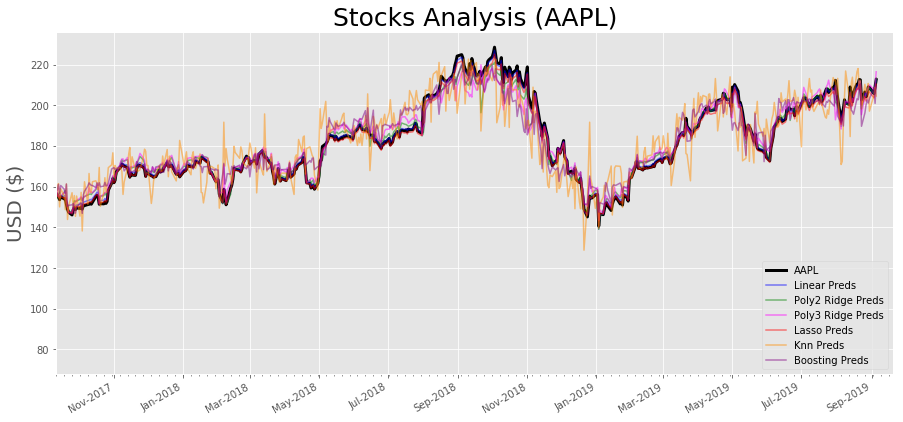

In [0]:
#recent_date = df.index.max()
display_at = 500
alpha = 0.5

# Adjusting the style of matplotlib
#style.use('ggplot')

#Create fig to plot
fig, ax = plt.subplots()

##Data
plt.plot(close_px.tail(display_at), label=name, c='black', linewidth=3)

##Real Prediction
plt.plot(df_full.index[-display_at:], linear_model_real_prediction[-display_at:], label='Linear Preds', c='blue', alpha=alpha)
#plt.plot(predicted_dates, linear_model_forecast_prediction, c='blue', alpha=alpha)

plt.plot(df_full.index[display_at:], quad_poly2_ridge_model_real_prediction[display_at:], label='Poly2 Ridge Preds', c='green', alpha=alpha)
#plt.plot(predicted_dates, quad_poly2_ridge_model_forecast_prediction, c='green', alpha=alpha)

plt.plot(df_full.index[display_at:], quad_poly3_ridge_model_real_prediction[display_at:], label='Poly3 Ridge Preds', c='magenta', alpha=alpha)
#plt.plot(predicted_dates, quad_poly3_ridge_model_forecast_prediction, c='magenta', alpha=alpha)

plt.plot(df_full.index[display_at:], lasso_model_real_prediction[display_at:], label='Lasso Preds', c='red', alpha=alpha)
#plt.plot(predicted_dates, lasso_model_forecast_prediction, c='red', alpha=alpha)

plt.plot(df_full.index[display_at:], knn_model_real_prediction[display_at:], label='Knn Preds', c='darkorange', alpha=alpha)
#plt.plot(predicted_dates, knn_model_forecast_prediction, c='darkorange', alpha=alpha)

plt.plot(df_full.index[display_at:], boosting_model_real_prediction[display_at:], label='Boosting Preds', c='purple', alpha=alpha)
#plt.plot(predicted_dates, boosting_model_forecast_prediction, c='purple', alpha=alpha)

plt.legend(loc=4)
#plt.xlabel('Date', fontsize = 20)
plt.ylabel('USD ($)', fontsize = 20)

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator(range(1, 13), bymonthday=1, interval=2)  # every month
monthsFmt = mdates.DateFormatter("%b-%Y")
# every monday
mondays = mdates.WeekdayLocator(MONDAY)

if (display_at < 100):
  dayFmt = mdates.DateFormatter("%b,%d-%Y")
  ax.xaxis.set_major_locator(mondays)
  ax.xaxis.set_major_formatter(dayFmt)
else:
  if (len(df_full) > 1500):
    # format the ticks
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    ax.xaxis.set_minor_locator(months)
  else:
    #years_fmt = mdates.DateFormatter('%Y-%b')
    # format the ticks
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(monthsFmt)
    ax.xaxis.set_minor_locator(mondays)

# round to nearest years.
datemin = np.datetime64(dfreg.index[-display_at-forecast_out])
#datemin = np.datetime64(dfreg.index.min())
datemax = np.datetime64(dfreg.index.max()) + np.timedelta64(1)
ax.set_xlim(datemin, datemax)

#format the coords message box
ax.format_xdata = mdates.DateFormatter('%b,%d-%Y')
ax.set_title('Stocks Analysis (%s)'%name, fontsize = 25)
ax.autoscale_view()

ax.grid(True)
fig.autofmt_xdate()
plt.show()

In [0]:
df_pr = pd.DataFrame({'Date': predicted_dates,
                      'Linear': linear_model_forecast_prediction,
                      'Poly2_ridge': quad_poly2_ridge_model_forecast_prediction,
                      'Poly3_ridge': quad_poly3_ridge_model_forecast_prediction,
                      'Lasso': lasso_model_forecast_prediction,
                      'Knn': knn_model_forecast_prediction,
                      'Boosting': boosting_model_forecast_prediction})

df_pr = df_pr.set_index('Date')
df_pr

,Linear,Poly2_ridge,Poly3_ridge,Lasso,Knn,Boosting
Date,,,,,,
2019-09-05,212.559998,212.559998,212.559998,212.559998,212.559998,212.559998
2019-09-06,201.511721,201.047386,203.317345,199.724207,213.766548,196.915167
2019-09-07,205.704491,203.450901,201.771612,204.229875,204.300026,195.583804
2019-09-08,209.796290,208.578422,208.462879,207.941047,216.382225,203.146028
2019-09-09,209.701264,208.082820,207.540517,207.903648,218.021782,202.644616
2019-09-10,212.154274,211.265231,211.647632,210.166878,208.186920,208.744440
2019-09-11,211.995046,211.100275,211.672705,209.982594,212.275955,210.565615
2019-09-12,201.851208,198.231302,195.335088,200.205843,198.059273,189.634841
2019-09-13,205.903491,204.454687,204.059783,204.250314,210.292656,196.157149


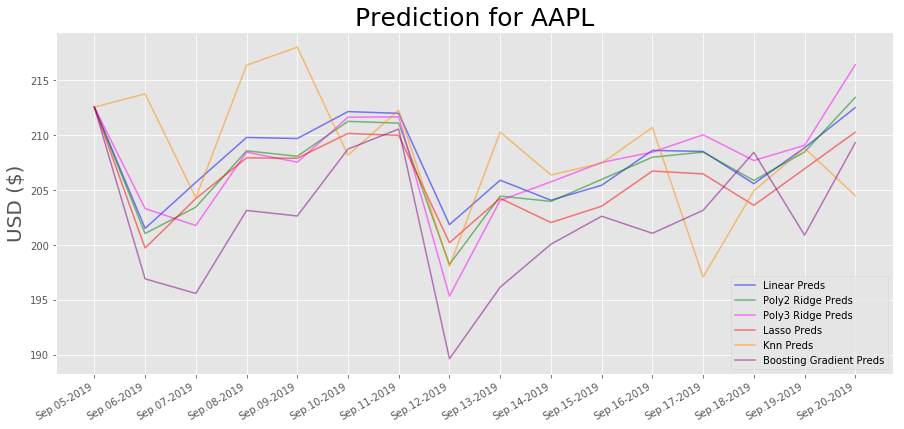

In [0]:
#Create fig to plot
fig, ax = plt.subplots()

plt.plot(predicted_dates, linear_model_forecast_prediction, c='blue', label='Linear Preds', alpha=alpha)
plt.plot(predicted_dates, quad_poly2_ridge_model_forecast_prediction, c='green', label='Poly2 Ridge Preds', alpha=alpha)
plt.plot(predicted_dates, quad_poly3_ridge_model_forecast_prediction, c='magenta', label='Poly3 Ridge Preds', alpha=alpha)
plt.plot(predicted_dates, lasso_model_forecast_prediction, c='red', label='Lasso Preds', alpha=alpha)
plt.plot(predicted_dates, knn_model_forecast_prediction, c='darkorange', label='Knn Preds', alpha=alpha)
plt.plot(predicted_dates, boosting_model_forecast_prediction, c='purple', label='Boosting Gradient Preds', alpha=alpha)

plt.legend(loc=4)
#plt.xlabel('Date', fontsize = 20)
plt.ylabel('USD ($)', fontsize = 20)

#format the coords message box
ax.format_xdata = mdates.DateFormatter('%b,%d-%Y')
ax.set_title('Prediction for %s'%name, fontsize = 25)
ax.autoscale_view()

days = mdates.DayLocator()
fmt = mdates.DateFormatter("%b.%d-%Y")
ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(fmt)

ax.grid(True)
fig.autofmt_xdate()

plt.show()

## 2. Strategie using old data

In this notebook, we will explore stock price prediction using three methods:

*  Linear Regression using  L2  regularization or Ridge Regression
*  Gradient Boosting Regressors
*  Neural Network based approaches using 1D Convolutions, LSTM layers with a Huber loss

The source of the stock prices is from https://finance.yahoo.com/quote/TSLA/history?p=TSLA where I downloaded all of the stock prices for Tesla Inc. since they become a publicly traded company up until today's date (September 1st, 2019). The variable to predict is the Adjusted Close price.

If you are running this on Google Colab, please make sure you switch the runtime to GPU so when you run the cells using neural networks, it will train much faster.

First let's import all of the necessary packages we need, which include NumPy, Pandas, Matplotlib, Scikit-learn and Keras/Tensorflow.

[Tutorial Homework 2](https://colab.research.google.com/drive/19O4w8F-wQ3BqszS0K6Dn2GCG_Z4SLiIO#scrollTo=XWC7-CSg_rOL)

In [20]:
df = pd.read_csv('%s.csv'%name)
# Converts string to datetime
df['Date'] = pd.to_datetime(df.Date, format='%Y-%m-%d')
# Set the index of dataframe to date column
df.set_index('Date', inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,79.382858,79.575714,78.860001,79.018570,71.320679,58671200
2014-01-03,78.980003,79.099998,77.204285,77.282860,69.754066,98116900
2014-01-06,76.778572,78.114288,76.228569,77.704285,70.134438,103152700
2014-01-07,77.760002,77.994286,76.845711,77.148575,69.632866,79302300
2014-01-08,76.972855,77.937141,76.955711,77.637146,70.073868,64632400


In [21]:
# Get only the column to use
df_close = df.copy()
df_close.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_close.tail()

,Adj Close
Date,
2019-08-30,208.740005
2019-09-03,205.699997
2019-09-04,209.190002
2019-09-05,213.279999
2019-09-06,213.259995


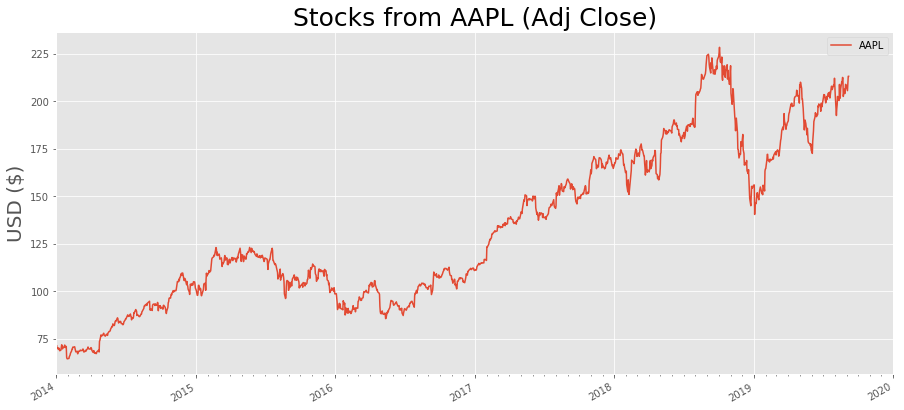

In [22]:
#Create fig to plot
fig, ax = plt.subplots()

plt.plot(df_close, label=name)
plt.legend()
#plt.xlabel('Date', fontsize = 20)
plt.ylabel('USD ($)', fontsize = 20)

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

# round to nearest years.
datemin = np.datetime64(df.index.min(), 'Y')
datemax = np.datetime64(df.index.max(), 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

#format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.set_title('Stocks from %s (Adj Close)'%name, fontsize = 25)
ax.grid(True)

fig.autofmt_xdate()
plt.show()

In [0]:
window_size = 32 # Allow us to look at 32 days into the past
# Prepare the data so that we have 32 day windows and predict what the next day should be

# Get indices of access for the data
num_samples = len(df) - window_size
indices = np.arange(num_samples).astype(np.int)[:,None] + np.arange(window_size + 1).astype(np.int)

In [0]:
data = df_close['Adj Close'].values[indices] # Create the 2D matrix of training samples
#print(len(data[0]))

In [30]:
X = data[:,:-1] # Each row represents 32 days in the past
y = data[:,-1]  # Each output value represents the 33rd day
print(X)

[[ 71.320679  69.754066  70.134438 ...  70.61908   70.562035  70.821465]
 [ 69.754066  70.134438  69.632866 ...  70.562035  70.821465  69.703331]
 [ 70.134438  69.632866  70.073868 ...  70.821465  69.703331  68.896507]
 ...
 [201.823181 206.435654 208.049515 ... 209.009995 208.740005 205.699997]
 [206.435654 208.049515 207.880173 ... 208.740005 205.699997 209.190002]
 [208.049515 207.880173 206.23642  ... 205.699997 209.190002 213.279999]]


Use 80% to train.

In [0]:
# Train and test split
split_fraction = 0.8
ind_split = int(split_fraction * num_samples)
X_train = X[:ind_split]
y_train = y[:ind_split]
X_test = X[ind_split:]
y_test = y[ind_split:]

### Method 1 - Ridge Regression

In [0]:
# Train
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)

# Infer
y_pred_train_ridge = ridge_model.predict(X_train)
y_pred_ridge = ridge_model.predict(X_test)

In [34]:
# Plot what it looks like for the training data
df_ridge = df_close.copy()
#df_ridge.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_ridge = df_ridge.iloc[window_size:ind_split] # Past 32 days we don't know yet
df_ridge['Adj Close Train'] = y_pred_train_ridge[:-window_size]

df_ridge.tail()

,Adj Close,Adj Close Train
Date,,
2018-06-05,189.690826,188.356338
2018-06-06,190.348297,189.835000
2018-06-07,189.838028,190.175203
2018-06-08,188.110962,189.996964
2018-06-11,187.649780,187.452083


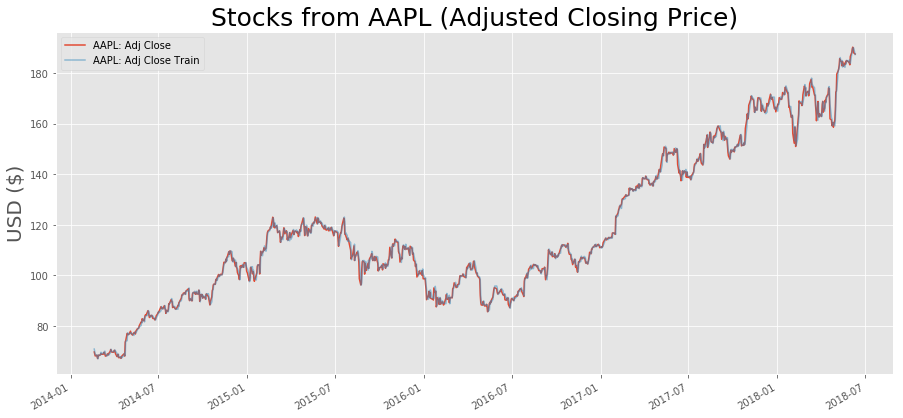

In [35]:
#Create fig to plot
fig, ax = plt.subplots()

plt.plot(df_ridge['Adj Close'], label='%s: Adj Close'%name)
plt.plot(df_ridge['Adj Close Train'], label='%s: Adj Close Train'%name,  alpha=0.5)
plt.legend()
plt.ylabel('USD ($)', fontsize = 20)
#format the coords message box
ax.set_title('Stocks from %s (Adjusted Closing Price)'%name, fontsize = 25)
ax.grid(True)
fig.autofmt_xdate()
plt.show()

In [36]:
# Plot what it looks like for the training data
df_ridge = df_close.copy()
#df_ridge.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_ridge = df_ridge.iloc[ind_split+window_size:] # Past 32 days we don't know yet
df_ridge['Adj Close Test'] = y_pred_ridge

df_ridge.tail()

,Adj Close,Adj Close Test
Date,,
2019-08-30,208.740005,209.222335
2019-09-03,205.699997,208.742581
2019-09-04,209.190002,204.680668
2019-09-05,213.279999,210.747743
2019-09-06,213.259995,213.565451


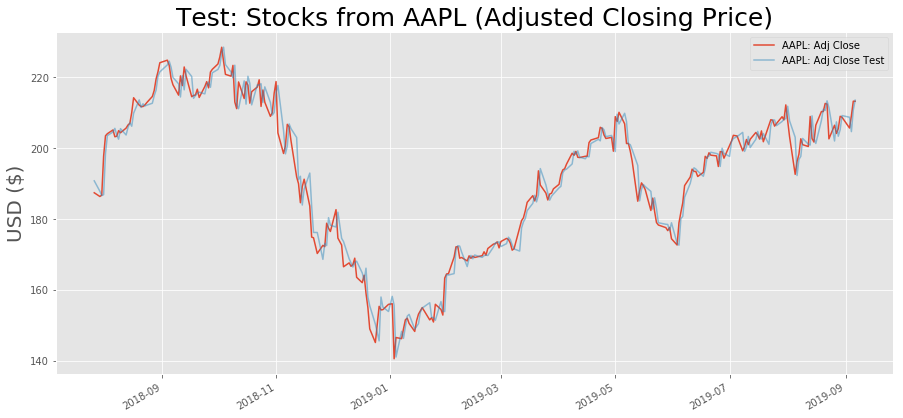

In [38]:
#Create fig to plot
fig, ax = plt.subplots()

plt.plot(df_ridge['Adj Close'], label='%s: Adj Close'%name)
plt.plot(df_ridge['Adj Close Test'], label='%s: Adj Close Test'%name,  alpha=0.5)
plt.legend()
plt.ylabel('USD ($)', fontsize = 20)
#format the coords message box
ax.set_title('Test: Stocks from %s (Adjusted Closing Price)'%name, fontsize = 25)
ax.grid(True)
fig.autofmt_xdate()
plt.show()

### Method 2: Gradient Boosting Trees

In [0]:
# Model #2 - Gradient Boosting Trees
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)

# Infer
y_pred_train_gb = gb_model.predict(X_train)
y_pred_gb = gb_model.predict(X_test)

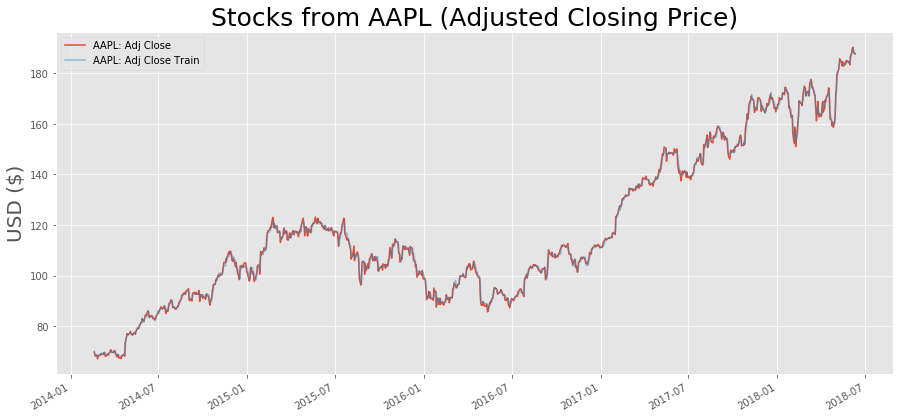

In [40]:
# Plot what it looks like for the training data
df_gb = df_close.copy()
#df_gb.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_gb = df_gb.iloc[window_size:ind_split] # Past 32 days we don't know yet
df_gb['Adj Close Train'] = y_pred_train_gb[:-window_size]
df_ridge.tail()

#df_gb.plot(label=name, figsize=(16,8), title='Adjusted Closing Price', grid=True)
#Create fig to plot
fig, ax = plt.subplots()

plt.plot(df_gb['Adj Close'], label='%s: Adj Close'%name)
plt.plot(df_gb['Adj Close Train'], label='%s: Adj Close Train'%name,  alpha=0.5)
plt.legend()
plt.ylabel('USD ($)', fontsize = 20)
#format the coords message box
ax.set_title('Stocks from %s (Adjusted Closing Price)'%name, fontsize = 25)
ax.grid(True)
fig.autofmt_xdate()
plt.show()

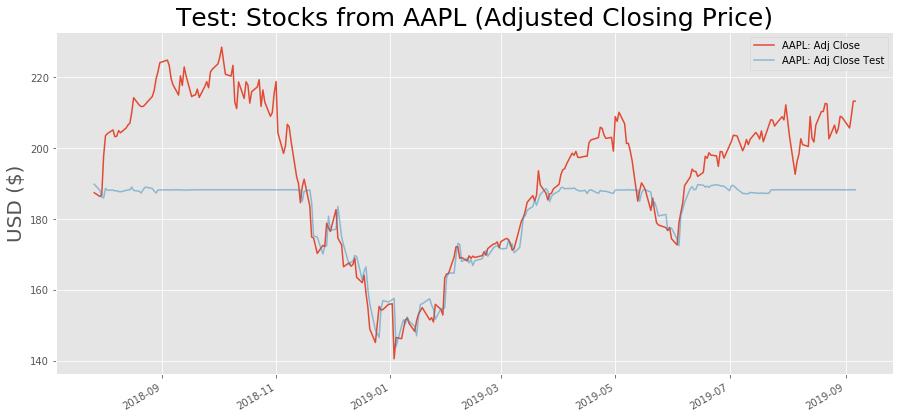

In [41]:
# Same for the test
df_gb = df_close.copy()
#df_gb.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_gb = df_gb.iloc[ind_split + window_size:] # Past 32 days we don't know yet
df_gb['Adj Close Test'] = y_pred_gb

#df_gb.plot(label=name, figsize=(16,8), title='Adjusted Closing Price', grid=True)
#Create fig to plot
fig, ax = plt.subplots()

plt.plot(df_gb['Adj Close'], label='%s: Adj Close'%name)
plt.plot(df_gb['Adj Close Test'], label='%s: Adj Close Test'%name,  alpha=0.5)
plt.legend()
plt.ylabel('USD ($)', fontsize = 20)
#format the coords message box
ax.set_title('Test: Stocks from %s (Adjusted Closing Price)'%name, fontsize = 25)
ax.grid(True)
fig.autofmt_xdate()
plt.show()

### Method 3: Using neural networks with 1D convolutional and LSTM layers

In [44]:
# Model #3 - Using RNNs
keras_model = Sequential([
  Conv1D(filters=128, kernel_size=5, input_shape=(window_size, 1), strides=1, padding="causal", activation="tanh"),
  Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="tanh"),
  LSTM(128, return_sequences=True),
  LSTM(128),
  Dense(64, activation="tanh"),
  Dense(64, activation="tanh"),
  Dense(1)
])

keras_model.summary()




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 32, 128)           768       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 32, 128)           82048     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32, 128)           131584    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)             

In [45]:
# First figure out the right learning rate
lr_schedule = LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = SGD(lr=1e-8, momentum=0.9)
keras_model.compile(loss=Huber(),
                    optimizer=optimizer,
                    metrics=["mae"])

# Scale the data due to LSTM units
scaler = MinMaxScaler(feature_range=(-1, 1))
data_transform = scaler.fit_transform(df['Adj Close'].values[:,None])
data_transform = data_transform[indices]
X2 = data_transform[:,:-1]
y2 = data_transform[:,-1]
X_train_reshape = X2[:ind_split]
y_train_reshape = y2[:ind_split]
X_test_reshape = X2[ind_split:]
y_test_reshape = y2[ind_split:]

In [46]:
history = keras_model.fit(X_train_reshape, y_train_reshape, batch_size=256, epochs=250, callbacks=[lr_schedule], validation_data=(X_test_reshape, y_test_reshape))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1118 samples, validate on 280 samples
Epoch 1/250
1118/1118 [==============================] - 5s 5ms/step - loss: 0.1330 - mean_absolute_error: 0.4575 - val_loss: 0.1985 - val_mean_absolute_error: 0.5756
Epoch 2/250
1118/1118 [==============================] - 3s 3ms/step - loss: 0.1330 - mean_absolute_error: 0.4575 - val_loss: 0.1985 - val_mean_absolute_error: 0.5756
Epoch 3/250
1118/1118 [==============================] - 3s 3ms/step - loss: 0.1330 - mean_absolute_error: 0.4575 - val_loss: 0.1985 - val_mean_absolute_error: 0.5756
Epoch 4/250
1118/1118 [==============================] - 3s 3ms/step - loss: 0.1330 - mean_absolute_error: 0.4575 - val_loss: 0.1985 - val_mean_absolute_error: 0.5756
Epoch 5/250
1118/1118 [==============================] - 3s 3ms/step - loss: 0.1330 - mean_absolute_error: 0.4575 - val_loss: 0.1985 - val_mean_absolute_error: 0.5756
Epoch 6/250
1118/1118 

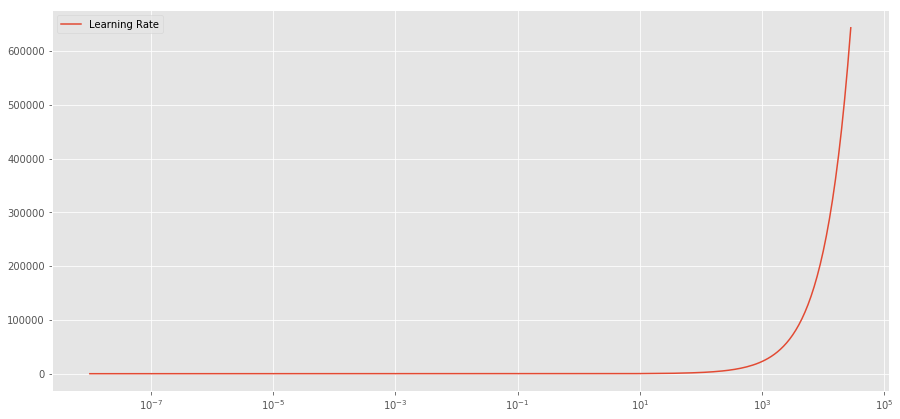

In [47]:
plt.semilogx(history.history['lr'], history.history['val_loss'])
plt.legend(['Learning Rate', 'Validation Loss'])

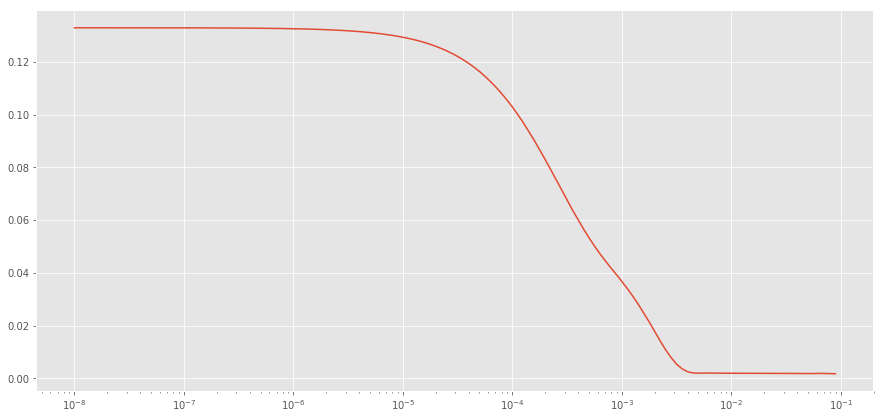

In [48]:
plt.semilogx(history.history['lr'][:140], history.history['loss'][:140])

In [49]:
# Observing the above graph, 0.1 seems to be the best learning rate
keras_model = Sequential([
  Conv1D(filters=128, kernel_size=5, input_shape=(window_size, 1), strides=1, padding="causal", activation="tanh"),
  Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="tanh"),
  LSTM(128, return_sequences=True),
  LSTM(128),
  Dense(64, activation="tanh"),
  Dense(64, activation="tanh"),
  Dense(1)
])

optimizer = SGD(lr=0.1, momentum=0.9)
keras_model.compile(loss=Huber(),
                    optimizer=optimizer,
                    metrics=["mae"])
history = keras_model.fit(X_train_reshape, y_train_reshape, batch_size=256, epochs=250, validation_data=(X_test_reshape, y_test_reshape))

Train on 1118 samples, validate on 280 samples
Epoch 1/250
1118/1118 [==============================] - 5s 4ms/step - loss: 0.0754 - mean_absolute_error: 0.3199 - val_loss: 0.0194 - val_mean_absolute_error: 0.1466
Epoch 2/250
1118/1118 [==============================] - 3s 3ms/step - loss: 0.0302 - mean_absolute_error: 0.2061 - val_loss: 0.0170 - val_mean_absolute_error: 0.1620
Epoch 3/250
1118/1118 [==============================] - 3s 3ms/step - loss: 0.0161 - mean_absolute_error: 0.1496 - val_loss: 0.0357 - val_mean_absolute_error: 0.2381
Epoch 4/250
1118/1118 [==============================] - 3s 2ms/step - loss: 0.0091 - mean_absolute_error: 0.1142 - val_loss: 0.0105 - val_mean_absolute_error: 0.1122
Epoch 5/250
1118/1118 [==============================] - 3s 3ms/step - loss: 0.0054 - mean_absolute_error: 0.0856 - val_loss: 0.0293 - val_mean_absolute_error: 0.2085
Epoch 6/250
1118/1118 [==============================] - 3s 3ms/step - loss: 0.0047 - mean_absolute_error: 0.0760 - va

In [0]:
y_pred_train_keras = scaler.inverse_transform(keras_model.predict(X_train_reshape, batch_size=256))
y_pred_keras = scaler.inverse_transform(keras_model.predict(X_test_reshape, batch_size=256))

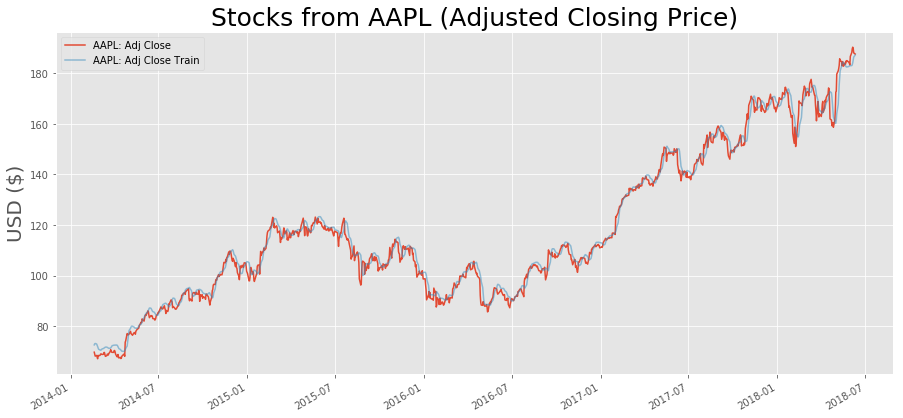

In [51]:
# Plot what it looks like for the training data
df_keras = df_close.copy()
#df_keras.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_keras = df_keras.iloc[window_size:ind_split] # Past 32 days we don't know yet
df_keras['Adj Close Train'] = y_pred_train_keras[:-window_size]

#df_keras.plot(label=name, figsize=(16,8), title='Adjusted Closing Price', grid=True)
#Create fig to plot
fig, ax = plt.subplots()

plt.plot(df_keras['Adj Close'], label='%s: Adj Close'%name)
plt.plot(df_keras['Adj Close Train'], label='%s: Adj Close Train'%name,  alpha=0.5)
plt.legend()
plt.ylabel('USD ($)', fontsize = 20)
#format the coords message box
ax.set_title('Stocks from %s (Adjusted Closing Price)'%name, fontsize = 25)
ax.grid(True)
fig.autofmt_xdate()
plt.show()

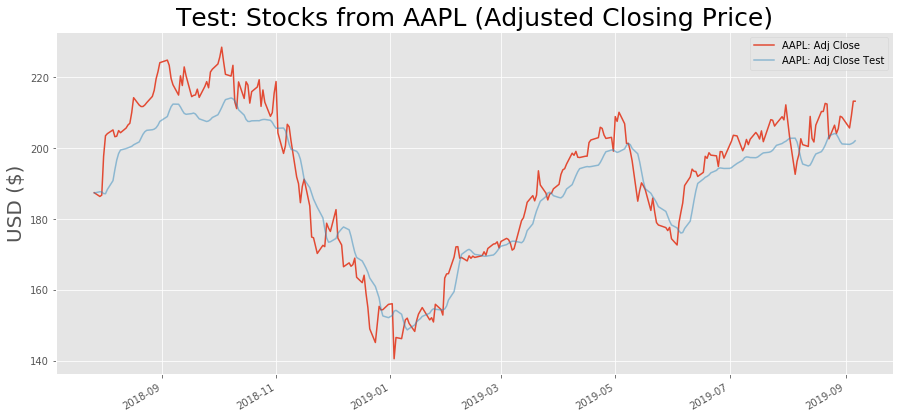

In [52]:
# Same for the test
df_keras = df_close.copy()
#df_keras.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_keras = df_keras.iloc[ind_split+window_size:] # Past 32 days we don't know yet
df_keras['Adj Close Test'] = y_pred_keras

#df_keras.plot(label=name, figsize=(16,8), title='Adjusted Closing Price', grid=True)
#Create fig to plot
fig, ax = plt.subplots()

plt.plot(df_keras['Adj Close'], label='%s: Adj Close'%name)
plt.plot(df_keras['Adj Close Test'], label='%s: Adj Close Test'%name,  alpha=0.5)
plt.legend()
plt.ylabel('USD ($)', fontsize = 20)
#format the coords message box
ax.set_title('Test: Stocks from %s (Adjusted Closing Price)'%name, fontsize = 25)
ax.grid(True)
fig.autofmt_xdate()
plt.show()

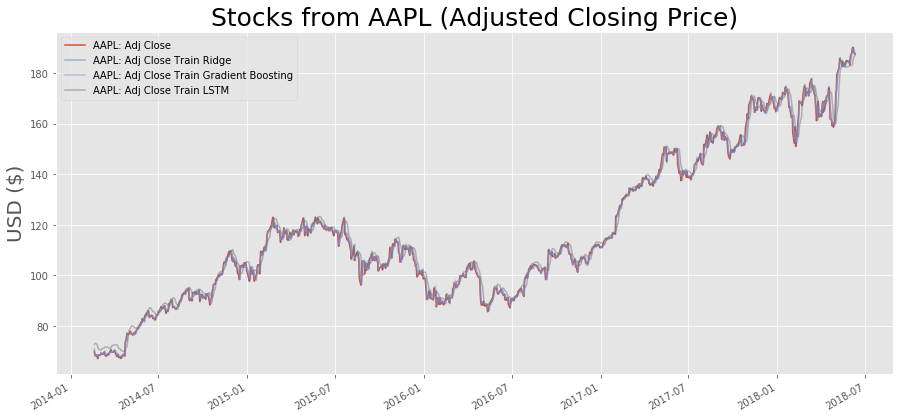

In [53]:
df_train = df_close.copy()
#df_train.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_train = df_train.iloc[window_size:ind_split] # Past 32 days we don't know yet
# Add in all of our methods
df_train['Adj Close Train Ridge'] = y_pred_train_ridge[:-window_size]
df_train['Adj Close Train Gradient Boosting'] = y_pred_train_gb[:-window_size]
df_train['Adj Close Train LSTM'] = y_pred_train_keras[:-window_size]

# Plot the data now
#df_train.plot(label=name, figsize=(16,8), title='Adjusted Closing Price', grid=True)
#Create fig to plot
fig, ax = plt.subplots()

plt.plot(df_train['Adj Close'], label='%s: Adj Close'%name)
plt.plot(df_train['Adj Close Train Ridge'], label='%s: Adj Close Train Ridge'%name,  alpha=0.5)
plt.plot(df_train['Adj Close Train Gradient Boosting'], label='%s: Adj Close Train Gradient Boosting'%name,  alpha=0.5)
plt.plot(df_train['Adj Close Train LSTM'], label='%s: Adj Close Train LSTM'%name,  alpha=0.5)
plt.legend()
plt.ylabel('USD ($)', fontsize = 20)
#format the coords message box
ax.set_title('Stocks from %s (Adjusted Closing Price)'%name, fontsize = 25)
ax.grid(True)
fig.autofmt_xdate()
plt.show()

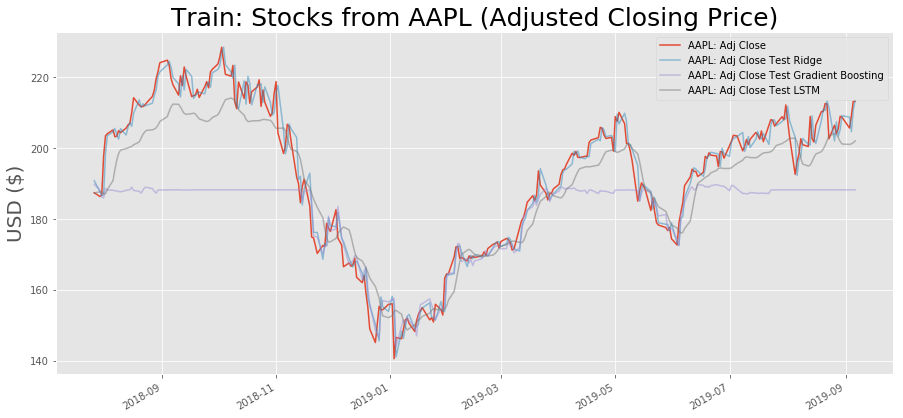

In [54]:
df_test = df_close.copy()
#df_test.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_test = df_test.iloc[ind_split+window_size:] # Past 32 days we don't know yet
# Add in all of our methods
df_test['Adj Close Test Ridge'] = y_pred_ridge
df_test['Adj Close Test Gradient Boosting'] = y_pred_gb
df_test['Adj Close Test LSTM'] = y_pred_keras

# Plot the data now
#df_test.plot(label=name, figsize=(16,8), title='Adjusted Closing Price', grid=True)
#Create fig to plot
fig, ax = plt.subplots()

plt.plot(df_test['Adj Close'], label='%s: Adj Close'%name)
plt.plot(df_test['Adj Close Test Ridge'], label='%s: Adj Close Test Ridge'%name,  alpha=0.5)
plt.plot(df_test['Adj Close Test Gradient Boosting'], label='%s: Adj Close Test Gradient Boosting'%name,  alpha=0.5)
plt.plot(df_test['Adj Close Test LSTM'], label='%s: Adj Close Test LSTM'%name,  alpha=0.5)
plt.legend()
plt.ylabel('USD ($)', fontsize = 20)
#format the coords message box
ax.set_title('Train: Stocks from %s (Adjusted Closing Price)'%name, fontsize = 25)
ax.grid(True)
fig.autofmt_xdate()
plt.show()

### Prediction



In [0]:
num_days = 10 # Let's try and forecase the next 10 days or two years

# Get the last window_size (32) days
data_seed = df['Adj Close'].values[-window_size:][None]
# Get the normalized data as well for the neural network
data_seed_norm = scaler.transform(data_seed)
input_values = {"ridge": data_seed, "gb": data_seed, "keras": data_seed_norm.copy()}
values = {"ridge": [], "gb": [], "keras": []}

for i in range(num_days): # For each day...
    # Predict the next price given the previous N prices
    values["ridge"].append(ridge_model.predict(input_values["ridge"])[0])
    values["gb"].append(gb_model.predict(input_values["gb"])[0])
    values["keras"].append(keras_model.predict(input_values["keras"][...,None])[0][0])

    # Dump the oldest price and put the newest price at the end
    for v in input_values:
        val = input_values[v]
        val = np.insert(val, -1, values[v][-1], axis=1)
        val = np.delete(val, 0, axis=1)
        input_values[v] = val.copy()

# Convert all to NumPy arrays
for v in input_values:
    values[v] = np.array(values[v])

# Unnormalize prices from NN approach
values["keras"] = scaler.inverse_transform(values["keras"][None])[0]

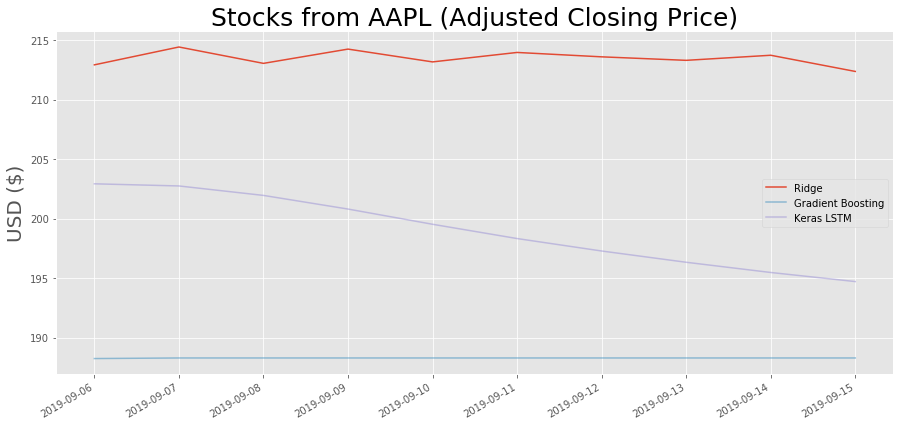

In [57]:
# last_date = datetime.strptime(df.index[-1], '%Y-%m-%d')
df_forecast = pd.DataFrame()
df_forecast["Ridge"] = values["ridge"]
df_forecast["Gradient Boosting"] = values["gb"]
df_forecast["Keras LSTM"] = values["keras"]
df_forecast.index = pd.date_range(start=df.index[-1], periods=num_days)

#Plot
#df_forecast.plot(label=name, figsize=(16,8), title='Forecasted Adjusted Closing Price', grid=True)
#Create fig to plot
fig, ax = plt.subplots()

plt.plot(df_forecast['Ridge'], label='Ridge')
plt.plot(df_forecast['Gradient Boosting'], label='Gradient Boosting',  alpha=0.5)
plt.plot(df_forecast['Keras LSTM'], label='Keras LSTM',  alpha=0.5)
plt.legend()
plt.ylabel('USD ($)', fontsize = 20)
#format the coords message box
ax.set_title('Stocks from %s (Adjusted Closing Price)'%name, fontsize = 25)
ax.grid(True)
fig.autofmt_xdate()
plt.show()